In [1]:
# Imports
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torchsummary import summary
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import time
import json
import copy
import random
import os
import os.path as osp
from pprint import pprint

import importlib
import sys
import pickle

sys.path.append('../')

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)

from ogb.nodeproppred import Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import time
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx

In [2]:
def create_erdos_renyi_graphs(sizes, p=0.1, seed=None, save_dir_graphs="./er_graphs", save_dir_data="./er_data"):
    os.makedirs(save_dir_graphs, exist_ok=True)
    os.makedirs(save_dir_data, exist_ok=True)
    graphs_nx = []
    graphs_data = []

    for n in sizes:
        graph_path = os.path.join(save_dir_graphs, f"er_graph_{n}.gpickle")
        data_path = os.path.join(save_dir_data, f"er_graph_{n}.pt")

        # Load or create graph
        if os.path.exists(graph_path):
            with open(graph_path, "rb") as f:
                G = pickle.load(f)
            print(f"Successfully loaded from {graph_path}")
        else:
            G = nx.erdos_renyi_graph(n=n, p=p, seed=seed)
            G = utils.add_louvain_community_labels(G)
            with open(graph_path, "wb") as f:
                pickle.dump(G, f)
            print(f"Saved new graph to {graph_path}")

        graphs_nx.append(G)

        # Load or create Data object
        if os.path.exists(data_path):
            data = torch.load(data_path)
            print(f"Successfully loaded Data from {data_path}")
        else:
            data = from_networkx(G)
            data = utils.create_masks(data)
            torch.save(data, data_path)
            print(f"Saved new Data to {data_path}")

        graphs_data.append(data)

    return graphs_nx, graphs_data

# Usage
sizes = [10, 100, 1000,10000]
graphs_nx, graphs_data = create_erdos_renyi_graphs(sizes, p=0.1)
print([len(g.nodes) for g in graphs_nx])
print(graphs_data)

Successfully loaded from ./er_graphs\er_graph_10.gpickle
Successfully loaded Data from ./er_data\er_graph_10.pt
Successfully loaded from ./er_graphs\er_graph_100.gpickle
Successfully loaded Data from ./er_data\er_graph_100.pt
Successfully loaded from ./er_graphs\er_graph_1000.gpickle
Successfully loaded Data from ./er_data\er_graph_1000.pt


C:\Users\csaba\AppData\Local\Temp\ipykernel_9888\2887371443.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Saved new graph to ./er_graphs\er_graph_10000.gpickle
Saved new Data to ./er_data\er_graph_10000.pt
[10, 100, 1000, 10000]
[Data(edge_index=[2, 18], y=[10], num_nodes=10, train_mask=[10], test_mask=[10]), Data(edge_index=[2, 940], y=[100], num_nodes=100, train_mask=[100], test_mask=[100]), Data(edge_index=[2, 100098], y=[1000], num_nodes=1000, train_mask=[1000], test_mask=[1000]), Data(edge_index=[2, 9991262], y=[10000], num_nodes=10000, train_mask=[10000], test_mask=[10000])]


Using device: cpu
Random seed set to: 42
Data(edge_index=[2, 18], y=[10], num_nodes=10, train_mask=[10], test_mask=[10])
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 1 epochs...


Epoch: 001, Loss: 8.9737, Acc: 0.3333, Duration: 0.54s
Dataset name: Unknown
    New best model saved with accuracy: 0.3333

Training finished.
Total elapsed time: 0.55 seconds
Best test accuracy: 0.3333
Best model state saved to '../training_data/models/node2vec_'


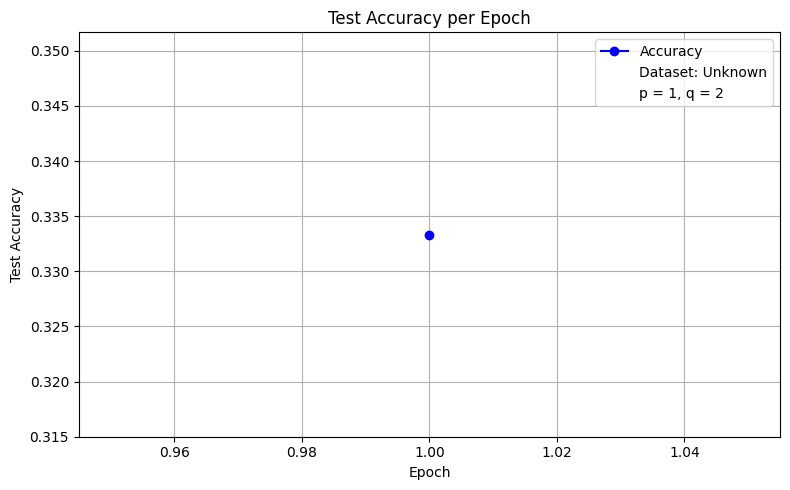

Elapsed time for graph with 10 nodes: 2.07 seconds
Data(edge_index=[2, 940], y=[100], num_nodes=100, train_mask=[100], test_mask=[100])
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 1 epochs...


Epoch: 001, Loss: 10.3196, Acc: 0.2000, Duration: 6.47s
Dataset name: Unknown
    New best model saved with accuracy: 0.2000

Training finished.
Total elapsed time: 6.48 seconds
Best test accuracy: 0.2000
Best model state saved to '../training_data/models/node2vec_'


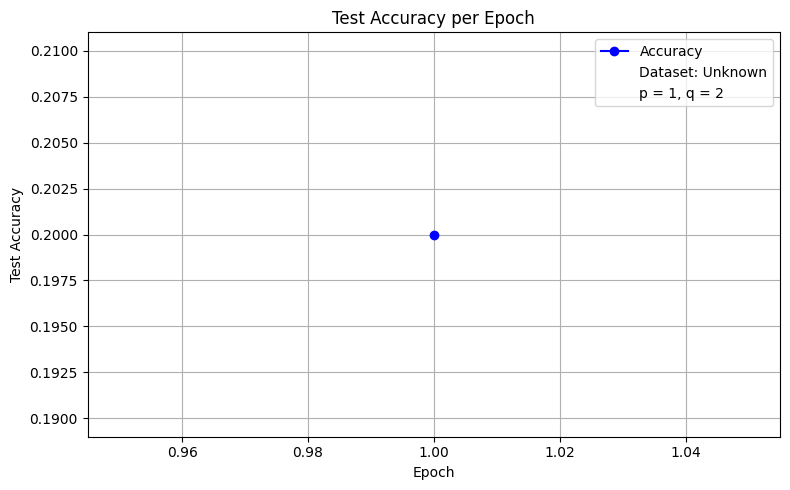

Elapsed time for graph with 100 nodes: 7.03 seconds
Data(edge_index=[2, 100098], y=[1000], num_nodes=1000, train_mask=[1000], test_mask=[1000])
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 1 epochs...


Epoch: 001, Loss: 9.3784, Acc: 0.1000, Duration: 41.78s
Dataset name: Unknown
    New best model saved with accuracy: 0.1000

Training finished.
Total elapsed time: 41.80 seconds
Best test accuracy: 0.1000
Best model state saved to '../training_data/models/node2vec_'


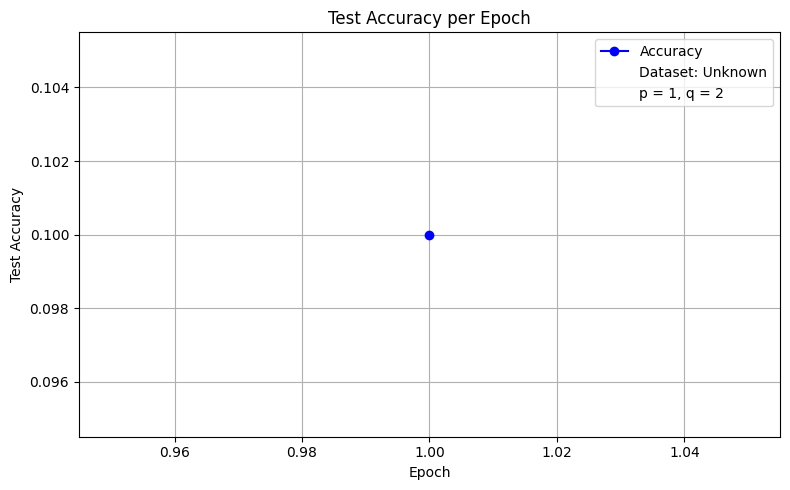

Elapsed time for graph with 1000 nodes: 42.16 seconds
Data(edge_index=[2, 9991262], y=[10000], num_nodes=10000, train_mask=[10000], test_mask=[10000])
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 1 epochs...


Epoch: 001, Loss: 6.6329, Acc: 0.1450, Duration: 368.92s
Dataset name: Unknown
    New best model saved with accuracy: 0.1450

Training finished.
Total elapsed time: 368.94 seconds
Best test accuracy: 0.1450
Best model state saved to '../training_data/models/node2vec_'


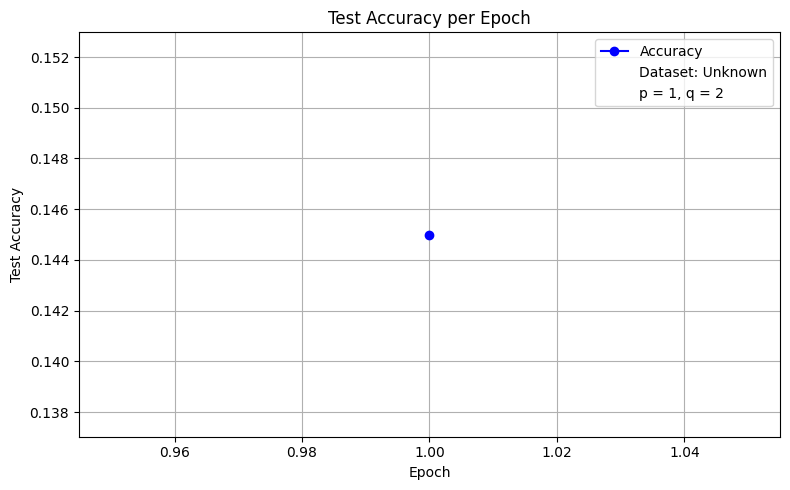

Elapsed time for graph with 10000 nodes: 369.70 seconds


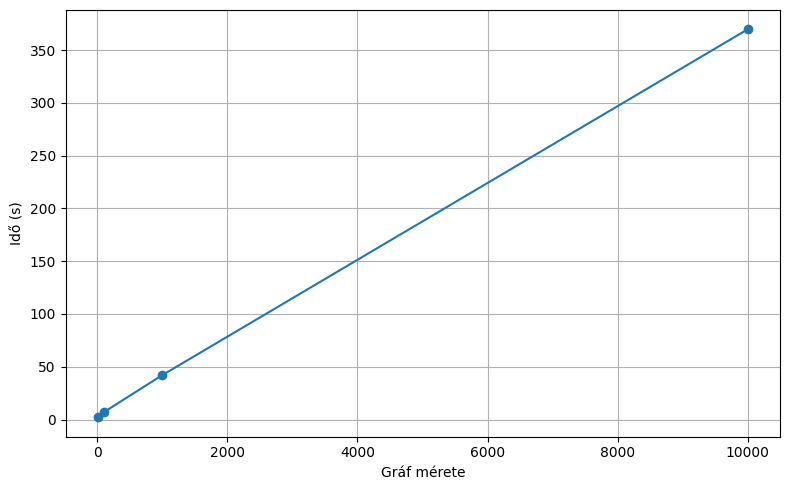

In [ ]:
device = utils.set_seeds_and_device() 
elapsed_times = []
graph_sizes = [data.num_nodes for data in graphs_data]

for data in graphs_data:
    print(data)
    parameter_dict = {
        "embedding_dim": 128,
        "walk_length": 80,
        "context_size": 10,
        "walks_per_node": 10,
        "num_negative_samples": 1,
        "sparse": True,
        "q": 2,
        "p": 1
    }

    start_time = time.time()

    model = training.model_init(parameter_dict, data)
    loader, optimizer = training.set_loader_and_optimizer(model)
    num_training_epochs = 1  # Or 201, etc.

    best_state, training_history = training.model_training_n2v(
        model,
        parameter_dict,
        data,
        loader,
        optimizer,
        num_training_epochs,
        device,
        model_save_path='../training_data/models/node2vec_'  # Example save path
    )

    elapsed = time.time() - start_time
    elapsed_times.append(elapsed)
    print(f"Elapsed time for graph with {data.num_nodes} nodes: {elapsed:.2f} seconds")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(graph_sizes, elapsed_times, marker='o')
plt.xlabel('Gráf mérete', fontsize=10)
plt.ylabel('Idő (s)', fontsize=10)
plt.xscale('log')
plt.yscale('log')
# plt.title('Node2Vec Training Time vs Graph Size', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [4]:
!pip list

Package                            Version
---------------------------------- --------------
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alembic                            1.14.1
annotated-types                    0.7.0
anyio                              4.7.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
arrow                              1.3.0
asttokens                          3.0.0
async-lru                          2.0.4
async-timeout                      5.0.1
attrs                              24.3.0
babel                              2.16.0
beautifulsoup4                     4.12.3
bleach                             6.2.0
blinker                            1.9.0
cachetools                         5.5.2
certifi                            2024.12.14
cffi                               1.17.1
charset-normalizer                 3.4.1
click                           